# Importing frameworks

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import  SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint



# Importing a datasets

In [2]:
#data for training the model
train = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv', encoding='ISO-8859–1')

#data for testing 
test = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Test.csv', encoding='ISO-8859–1')

# Data description

## Input variables:
**vID** - Unique ID (can not be used for predictions)

**Gender** - Sex

**City** - Current City

**Monthly_Income** - Monthly Income in rupees

**DOB** - Date of Birth

**Lead_Creation_Date** - Lead Created on date

**Loan_Amount_Applied** - Loan Amount Requested (INR)

**Loan_Tenure_Applied** - Loan Tenure Requested (in years)

**Existing_EMI** - EMI of Existing Loans (INR)

**Employer_Name** - Employer Name

**Salary_Account** - Salary account with Bank

**Mobile_Verified** - Mobile Verified (Y/N)

**Var5** - Continuous classified variable

**Var1** - Categorical variable with multiple levels

**Loan_Amount_Submitted** - Loan Amount Revised and Selected after seeing Eligibility

**Loan_Tenure_Submitted** - Loan Tenure Revised and Selected after seeing Eligibility (Years)

**Interest_Rate** - Interest Rate of Submitted Loan Amount

**Processing_Fee** - Processing Fee of Submitted Loan Amount (INR)

**EMI_Loan_Submitted** - EMI of Submitted Loan Amount (INR)

**Filled_Form** - Filled Application form post quote

**Device_Type** - Device from which application was made (Browser/ Mobile)

**Var2** - Categorical Variable with multiple Levels

**Source** - Categorical Variable with multiple Levels

**Var4** - Categorical Variable with multiple Levels

## Outcomes:

**LoggedIn**- Application Logged (Variable for understanding the problem – cannot be used in prediction)

**Disbursed**- Loan Disbursed (Target Variable)

# Target
## **Identify the customers segments having higher conversion ratio for a specific loan product** 

In [3]:
df = train.copy()[:500]

In [4]:
df.shape

(500, 26)

In [5]:
df.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     500 non-null    object 
 1   Gender                 500 non-null    object 
 2   City                   500 non-null    object 
 3   Monthly_Income         500 non-null    int64  
 4   DOB                    500 non-null    object 
 5   Lead_Creation_Date     500 non-null    object 
 6   Loan_Amount_Applied    500 non-null    float64
 7   Loan_Tenure_Applied    500 non-null    float64
 8   Existing_EMI           500 non-null    float64
 9   Employer_Name          500 non-null    object 
 10  Salary_Account         463 non-null    object 
 11  Mobile_Verified        500 non-null    object 
 12  Var5                   500 non-null    int64  
 13  Var1                   500 non-null    object 
 14  Loan_Amount_Submitted  336 non-null    float64
 15  Loan_T

## Target variable distribution

In [7]:
print(df['Disbursed'].value_counts(normalize=True))

0    0.992
1    0.008
Name: Disbursed, dtype: float64


Dataset shows a large class imbalance. Only 1.4% of the study population had disbursed loans.

# Feature transformation  and selection

In [8]:
to_remove = ['ID', 'LoggedIn', 'Employer_Name', 'Source', 'Processing_Fee']
df = df.drop(to_remove, axis=1)

## City

In [9]:
def get_population(city):
    query = """
SELECT ?population WHERE {
  SERVICE wikibase:mwapi {
      bd:serviceParam mwapi:search'""" + city + """'.    
      bd:serviceParam mwapi:language "en" .    
      bd:serviceParam wikibase:api "EntitySearch" .
      bd:serviceParam wikibase:endpoint "www.wikidata.org" .
      bd:serviceParam wikibase:limit 1 .
      ?item wikibase:apiOutputItem mwapi:item .
  }
  ?item wdt:P1082 ?population
}
    """ 
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql",\
                           agent = "Mozilla/5.0 (X11; Linux x86_64)\
                            AppleWebKit/537.11 (KHTML, like Gecko)\
                             Chrome/23.0.1271.64 Safari/537.11")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    try:
          out = int(result['results']['bindings'][0]["population"]["value"])
    except IndexError:
          out = np.nan
    return out

In [10]:
def make_cities_df(data):
    population = {'city_name' : data.unique(), 'population' :\
                  [get_population(str(city)) for city in data.unique()]}
    return pd.DataFrame(population)


In [11]:
def calc_number_of_occurrences(data, drop=False):
    count = pd.DataFrame( {'name': data.value_counts(sort=False).keys(),\
                         'number_of_occurrences' : data.value_counts(sort=False).values})
    if drop == True:
        count = count.drop(['name'], axis=1)
    return count

In [12]:
def calc_quantiles(data, Q1=0.30, Q2=0.70, numeric_only=True):
    Q1 = data.quantile(Q1)
    Q2 = data.quantile(Q2)
    return Q1, Q2 

In [13]:
def create_categories(cities, Q1, Q2):
    cities['city_size'] = np.nan

    number = cities['number_of_occurrences'] 
    pop = cities['population']

    cities['city_size'].loc[pop <= Q1['population']] = 'small'
    cities['city_size'].loc[pop > Q1['population']] = 'medium'
    cities['city_size'].loc[pop > Q2['population']] = 'big'

    empty = cities.loc[cities['city_size'].isnull() == True]

    empty['city_size'].loc[number <= Q1['number_of_occurrences']] = 'small'
    empty['city_size'].loc[number > Q1['number_of_occurrences']] = 'medium'
    empty['city_size'].loc[number > Q2['number_of_occurrences']] = 'big'

    cities['city_size'].loc[cities['city_size'].isnull() == True] = empty['city_size']
    return cities 


In [14]:
cities = make_cities_df(df['City'])
count = calc_number_of_occurrences(df['City'], drop=True)
cities = pd.concat([cities, count], axis=1)
Q1_cities, Q2_cities = calc_quantiles(cities)
cities = create_categories(cities, Q1_cities, Q2_cities)
cities

,city_name,population,number_of_occurrences,city_size
0,Delhi,26495000.0,85,big
1,Mumbai,15414288.0,64,big
2,Panchkula,NaN,2,medium
3,Saharsa,156540.0,1,small
4,Bengaluru,11250000.0,45,big
...,...,...,...,...
105,Firozpur,NaN,1,small
106,Hubli,NaN,1,small
107,Bolangir,1648997.0,1,medium
108,Mehsana,184991.0,1,small


In [15]:
size = dict(zip(cities['city_name'], cities['city_size']))    
    
df['City'] = df['City'].map(size).fillna('medium')

df = df.drop(['City'], axis=1)

#nie używać pojedynczych liter w nazwach zmiennych

## DOB

In [16]:
def extract_year(date):
    year = pd.Timestamp(date).year
    if year > 2015:
        year = year - 100
    return 2015 - year

df['age'] = df['DOB'].apply(extract_year) 
df = df.drop(['DOB'], axis=1)

## Salary_Account

In [17]:
def create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account):
    count['category'] = np.nan
    count['category'].loc[count['number_of_occurrences'] <= Q1_Salary_Account[0]] = 'small'
    count['category'].loc[count['number_of_occurrences'] > Q1_Salary_Account[0]] = 'medium'
    count['category'].loc[count['number_of_occurrences'] > Q2_Salary_Account[0]] = 'big'

    return count

In [18]:
count = calc_number_of_occurrences(df['Salary_Account'])
Q1_Salary_Account, Q2_Salary_Account = calc_quantiles(count, Q1=0.90, Q2=0.97)
count = create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account)
size = {}
for i, n in enumerate(count['name']):
    size[n] = count['category'][i]
size

# użyć schematu jak w City

df['Salary_Account'] = df['Salary_Account'].map(size).fillna('big')



## Loan_Tenure_Applied & Loan_Amount_Applied

In [19]:
df['Loan_Tenure_Applied'].loc[df['Loan_Tenure_Applied'].isnull()]\
 = df['Loan_Tenure_Submitted'].loc[df['Loan_Tenure_Applied'].isnull()]

df['Loan_Amount_Applied'].loc[df['Loan_Amount_Applied'].isnull()]\
 = df['Loan_Amount_Submitted'].loc[df['Loan_Amount_Submitted'].isnull()]

## Interest_Rate

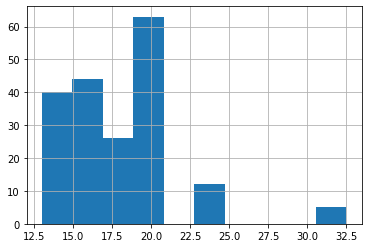

In [20]:
df['Interest_Rate'].hist()
plt.show()

In [21]:
df['Interest_Rate'].mean()

18.182105263157897

In [22]:
Interest_Rate_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['Interest_Rate'] = Interest_Rate_imp.fit_transform(df[['Interest_Rate']])

## Data transformation

In [23]:
class VIF (BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.correlated_data = []
        return

    def calc_vif(self, X):  
        vif_data = pd.DataFrame()
        vif_data['feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
        return vif_data

    def remove_correlated_data(self, X):
        self.correlated_data = []
        vif = self.calc_vif(X)
        to_remove = vif['feature'].loc[vif['VIF'] == max(vif['VIF'])]
        X = X.drop(to_remove.values, axis=1)
        self.correlated_data.append(to_remove.values)
        return X

    def fit(self, X, y=None, **kwargs):
        X = pd.DataFrame(X, columns=pipe_vif[:-1].get_feature_names_out())  
        while len(self.calc_vif(X)['feature'].
              loc[self.calc_vif(X)['VIF'] > 10]) > 0:
            X = self.remove_correlated_data(X)
        return self

    def transform(self, X, y=None, **kwargs):
        X = pd.DataFrame(X, columns = pipe_vif[:-1].get_feature_names_out())
        for i in self.correlated_data:
            X = X.drop(i, axis=1)
        return X

    def fit_transform(self, X, y=None, **kwargs):
        self.fit(X)
        return self.transform(X)



In [24]:
class MyTransformer:

    def __init__(self, transformer):
        self.transformer = transformer
    
    def fit(self, X, y=None, **kwargs):
        X = pd.DataFrame(X)
        self.transformer = ColumnTransformer([('transformer', self.transformer, X.keys())],
                                         verbose_feature_names_out=False, remainder='passthrough')
        self.transformer = self.transformer.fit(X)
        return self

    def transform(self, X, y=None, **kwargs):
        return pd.DataFrame(self.transformer.transform(X), 
                        columns=self.transformer.get_feature_names_out())

    def fit_transform(self, X, y=None, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.transformer.get_feature_names_out()

In [25]:
df = df.drop(['Lead_Creation_Date'], axis=1)

In [26]:
X = df.drop(['Disbursed'], axis=1)
y = df['Disbursed']

In [27]:
cols_numerical = X.select_dtypes(include=['int64', 'float64']).columns
 
transformer_numerical = Pipeline(steps = [('Imputer_num', 
                                           MyTransformer(SimpleImputer(missing_values=np.nan, 
                                                         strategy='constant',
                                                         fill_value=0))),
                                           ('Scaler',
                                            MyTransformer(StandardScaler()))])

cols_categorical = X.select_dtypes(include=['object']).columns
 
transformer_categorical = Pipeline(steps = [('Imputer_cat',
                                             MyTransformer(SimpleImputer(missing_values=np.nan,
                                                           strategy='most_frequent'))),
                                             ('Encoder', MyTransformer(OneHotEncoder(drop ='first',
                                                             handle_unknown='ignore', sparse=False)))])

In [28]:
preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)
], verbose_feature_names_out=False)

In [29]:
pipe_vif = Pipeline(steps = [('preprocessor', preprocessor),
                         ('vif', VIF())])
X = pipe_vif.fit_transform(X)

In [30]:
X

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,EMI_Loan_Submitted,age,...,Var1_HBXH,Var1_HBXX,Var1_HCXD,Var1_HVYS,Filled_Form_Y,Device_Type_Web-browser,Var2_C,Var2_E,Var2_F,Var2_G
0,-0.409811,-0.006518,1.281312,-0.431241,-1.076433,-0.879112,-1.286197,1.622567e-15,-0.600213,0.753296,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.109953,-0.199924,-0.180261,-0.431241,1.204146,-0.281036,-0.376581,-2.252551e+00,0.335578,-0.185641,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.359835,0.573700,0.794121,-0.431241,-1.076433,0.466559,0.533035,1.622567e-15,-0.600213,0.350894,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.109953,1.347323,1.281312,-0.431241,0.677858,1.872038,0.987843,1.622567e-15,-0.600213,-0.453909,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.189433,0.380294,-0.180261,2.407617,1.905862,0.616078,-0.376581,1.622567e-15,-0.600213,-0.051507,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.409811,-0.199924,-1.154642,-0.431241,-0.550146,-0.281036,0.987843,1.622567e-15,-0.600213,-0.051507,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,-0.209905,-0.199924,-0.180261,-0.431241,0.853287,-0.281036,-0.376581,3.735423e-01,0.794807,-0.319775,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
497,-0.439797,-0.586735,-1.154642,-0.431241,-0.901004,0.406751,0.987843,1.622567e-15,-0.600213,-0.185641,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
498,-0.209905,-0.586735,-1.154642,-0.431241,-0.199287,0.466559,0.987843,-6.540596e-01,0.938927,-0.051507,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [31]:
pipe_vif.named_steps.vif.correlated_data

[array(['Var4'], dtype=object)]

In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42) 

In [33]:
y_train.value_counts()

0    397
1      3
Name: Disbursed, dtype: int64

## Model

In [34]:
pipe_model = Pipeline(steps = [('model', None)])

In [35]:
param_grid = [
    
    {
        'model__class_weight' : [{0 : 0.001, 1 : 1}, {0 : 0.01, 1 : 1},
                                 {0 : 0.1, 1 : 1}, 'balanced'],
        'model__n_estimators' : sp_randint(200, 500),
        'model__max_depth' : np.arange(1, 11, 1),
        'model__min_samples_split' : np.arange(2, 10, 1),
        'model__min_samples_leaf' : sp_randint(1, 12),
        'model__ccp_alpha' : [0, 0.001, 0.01, 0.1, 5, 10, 50, 100, 500, 1000, 5000],
        'model': [RandomForestClassifier()]
    },
    {
        'model__class_weight' : [{0 : 0.001, 1 : 1}, {0 : 0.01, 1 : 1},
                                 {0 : 0.1, 1 : 1}, 'balanced'],
        'model__loss' : ['hinge', 'modified_huber'] ,
        'model__learning_rate' : ['constant', 'optimal', 'invscaling'],
        'model': [SGDClassifier(max_iter=10000, tol=1e-3)]
    },
    {
        'model__scale_pos_weight' : np.arange(50, 100, 1),
        'model__n_estimators' : sp_randint(10, 100),
        'model__max_depth': np.arange(2, 9),
        'model__learning_rate': np.arange(0.01, 0.3, 0.01),
        'model__colsample_bytree': np.arange(0.1, 1, 0.1),
        'model__gamma': np.arange(0, 20, 2),
        'model': [XGBClassifier()]
    }
]

grid = RandomizedSearchCV(pipe_model, param_grid, n_iter=10, scoring='roc_auc')
grid.fit(X_train, y_train)

D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_ranking.py", line 569, in roc_auc_score
    return _average_binary_score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_w

D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_ranking.py", line 569, in roc_auc_score
    return _average_binary_score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_w

D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_ranking.py", line 569, in roc_auc_score
    return _average_binary_score(
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_w

D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\anaconda\envs\myenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "D:\anaconda\envs\myenv\l

RandomizedSearchCV(estimator=Pipeline(steps=[('model', None)]),
                   param_distributions=[{'model': [RandomForestClassifier()],
                                         'model__ccp_alpha': [0, 0.001, 0.01,
                                                              0.1, 5, 10, 50,
                                                              100, 500, 1000,
                                                              5000],
                                         'model__class_weight': [{0: 0.001,
                                                                  1: 1},
                                                                 {0: 0.01,
                                                                  1: 1},
                                                                 {0: 0.1, 1: 1},
                                                                 'balanced'],
                                         'model__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'model__min_samples_leaf': <scipy.stats._dist...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                         'model__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                                         'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FBAC96F820>,
                                         'model__scale_pos_weight': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}],
                   scoring='roc_auc')

In [36]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [37]:
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ignore_index=True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,...,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016195,5.590365e-03,0.004000,1.095627e-03,"XGBClassifier(base_score=None, booster=None, c...",0.2,6,0.14,4,27,...,NaN,"{'model': XGBClassifier(base_score=None, boost...",NaN,0.641026,0.303797,NaN,NaN,NaN,NaN,1
1,0.002400,4.906413e-04,0.002000,7.688768e-07,SGDClassifier(max_iter=10000),NaN,NaN,optimal,NaN,NaN,...,NaN,"{'model': SGDClassifier(max_iter=10000), 'mode...",NaN,0.500000,0.582278,NaN,NaN,NaN,NaN,2
2,0.015600,1.019842e-03,0.003400,4.894147e-04,"XGBClassifier(base_score=None, booster=None, c...",0.5,0,0.29,2,44,...,NaN,"{'model': XGBClassifier(base_score=None, boost...",NaN,0.634615,0.620253,NaN,NaN,NaN,NaN,3
3,0.342907,6.312714e-03,0.027996,1.881001e-03,RandomForestClassifier(),NaN,NaN,NaN,4,296,...,3,"{'model': RandomForestClassifier(), 'model__cc...",NaN,0.500000,0.500000,NaN,NaN,NaN,NaN,4
4,0.485357,6.394124e-03,0.040418,4.873650e-04,RandomForestClassifier(),NaN,NaN,NaN,4,466,...,2,"{'model': RandomForestClassifier(), 'model__cc...",NaN,0.596154,0.253165,NaN,NaN,NaN,NaN,5
5,0.490594,1.180702e-02,0.038985,1.095213e-03,RandomForestClassifier(),NaN,NaN,NaN,10,442,...,4,"{'model': RandomForestClassifier(), 'model__cc...",NaN,0.500000,0.500000,NaN,NaN,NaN,NaN,6
6,0.011400,1.497084e-03,0.003599,4.905051e-04,"XGBClassifier(base_score=None, booster=None, c...",0.2,14,0.02,6,18,...,NaN,"{'model': XGBClassifier(base_score=None, boost...",NaN,0.570513,0.607595,NaN,NaN,NaN,NaN,7
7,0.002000,5.519789e-07,0.001999,1.142421e-06,SGDClassifier(max_iter=10000),NaN,NaN,optimal,NaN,NaN,...,NaN,"{'model': SGDClassifier(max_iter=10000), 'mode...",NaN,0.480769,0.822785,NaN,NaN,NaN,NaN,8
8,0.010800,3.998996e-04,0.003200,3.999951e-04,"XGBClassifier(base_score=None, booster=None, c...",0.3,0,0.14,8,18,...,NaN,"{'model': XGBClassifier(base_score=None, boost...",NaN,0.576923,0.164557,NaN,NaN,NaN,NaN,9
9,0.000200,3.997803e-04,0.000000,0.000000e+00,SGDClassifier(max_iter=10000),NaN,NaN,invscaling,NaN,NaN,...,NaN,"{'model': SGDClassifier(max_iter=10000), 'mode...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [38]:
grid.best_params_

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.2, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=6, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.14, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=27, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'model__colsample_bytree': 0.2,
 'model__gamma': 6,
 'model__learning_rate': 0.14,
 'model__max_depth': 4,
 'model__n_estimators': 27,
 'model__scale_pos_weight': 51}

In [39]:
pipe_model.set_params(**grid.best_params_)
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.2, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=6, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.14, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=27, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [40]:
roc_auc_score(y_test, pipe_model.predict_proba(X_test)[:,1])

0.98989898989899

In [41]:
y_test.sum()

1

In [42]:
pipe_model.predict_proba(X_test)

array([[0.9738401 , 0.0261599 ],
       [0.9824594 , 0.01754059],
       [0.93380105, 0.06619892],
       [0.9694586 , 0.03054144],
       [0.9708658 , 0.02913424],
       [0.9588408 , 0.04115921],
       [0.8935485 , 0.10645151],
       [0.9284336 , 0.07156639],
       [0.9751331 , 0.02486687],
       [0.9795636 , 0.02043639],
       [0.9738401 , 0.0261599 ],
       [0.9858286 , 0.01417143],
       [0.98523206, 0.01476795],
       [0.9721942 , 0.02780578],
       [0.9795636 , 0.02043639],
       [0.6047427 , 0.3952573 ],
       [0.96046686, 0.03953315],
       [0.9870183 , 0.01298173],
       [0.9860861 , 0.01391393],
       [0.9572465 , 0.04275353],
       [0.9738401 , 0.0261599 ],
       [0.9871378 , 0.0128622 ],
       [0.9876239 , 0.01237615],
       [0.98346853, 0.01653147],
       [0.77866566, 0.22133437],
       [0.93752974, 0.06247025],
       [0.9828068 , 0.0171932 ],
       [0.9613323 , 0.0386677 ],
       [0.9726669 , 0.02733309],
       [0.97955155, 0.02044846],
       [0.

In [43]:
def plot_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    return plt.show()

def get_results(model_name, model, X_test, y_test):
    auc = round(roc_auc_score(y_test, model.predict(X_test)), 3)
    precision = round(precision_score(y_test, model.predict(X_test)), 3)
    accuracy = round(accuracy_score(y_test, model.predict(X_test)), 3)
    print(f'model: {model_name}\n')
    print(f'accuracy_score: {accuracy}')
    print(f'roc_auc_score: {auc}')
    print(f'precision_score: {precision}\n')
    #dodać metrykę f1, recal
    plot_confusion_matrix(y_test=y_test, y_pred=model.predict(X_test))
    return auc

D:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=6, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.14, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=27, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy_score: 0.99
roc_auc_score: 0.5
precision_score: 0.0



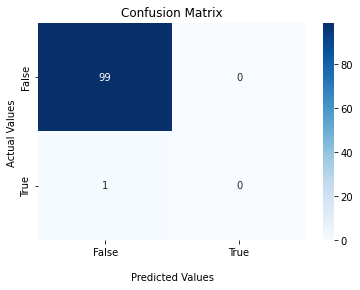

0.5

In [44]:
get_results(model_name=grid.best_params_['model'], model=pipe_model, X_test=X_test, y_test=y_test)

# Prediction of test data

In [45]:
test

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
0,ID000026A10,Male,Dehradun,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,100000.0,3.0,20.0,1000.0,2649.39,N,Web-browser,B,S122,3
1,ID000054C40,Male,Mumbai,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,690000.0,5.0,24.0,13800.0,19849.90,Y,Mobile,C,S133,5
2,ID000066O10,Female,Jaipur,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
3,ID000110G00,Female,Chennai,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S133,1
4,ID000113J30,Male,Chennai,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,100000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37712,ID124809J40,Female,Ponda,40000,28-Dec-71,31-Jul-15,1000000.0,4.0,10000.0,GOVT EMPLOYEE,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,3
37713,ID124817R20,Male,Chandigarh,20500,09-Feb-84,31-Jul-15,0.0,0.0,0.0,MAX SUPER SPECIALITY HOSPITAL MOHALI,...,330000.0,4.0,31.5,6600.0,12171.60,Y,Mobile,G,S122,5
37714,ID124820U00,Male,Meerut,25000,18-Dec-69,31-Jul-15,0.0,0.0,0.0,C.I.S.F,...,390000.0,4.0,NaN,NaN,NaN,N,Mobile,G,S122,3
37715,ID124822W20,Female,Kolkata,130000,01-Jan-72,31-Jul-15,600000.0,0.0,67000.0,TATA STEEL LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1


In [46]:
train.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed'],
      dtype='object')

In [47]:
test.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4'],
      dtype='object')

In [48]:
for key in test.keys():
    if key not in train.keys():
        test = test.drop([key], axis=1)

In [49]:
test.keys()

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4'],
      dtype='object')

In [50]:
cities = make_cities_df(test['City'])
count = calc_number_of_occurrences(test['City'], drop=True)
cities = pd.concat([cities, count], axis=1)
cities = create_categories(cities, Q1_cities, Q2_cities)

size = {}
for i, n in enumerate(cities['city_name']):
    size[n] = cities['city_size'][i]

test['City'] = test['City'].map(size).fillna('medium')

In [51]:
years = []
for year in test['Lead_Creation_Date']:
    years.append(pd.Timestamp(year).year)

test['age'] = date_to_years(test['DOB'], years)
test = test.drop(['DOB'], axis=1)

NameError: name 'date_to_years' is not defined

In [ ]:
count = calc_number_of_occurrences(test['Salary_Account'])
count = create_categories_salary(count, Q1_Salary_Account, Q2_Salary_Account)
size = {}
for i, n in enumerate(count['name']):
    size[n] = count['category'][i]
size
test['Salary_Account'] = test['Salary_Account'].map(size).fillna('big')

In [ ]:
test['Loan_Tenure_Applied'].loc[test['Loan_Tenure_Applied'].isnull()]\
 = test['Loan_Tenure_Submitted'].loc[test['Loan_Tenure_Applied'].isnull()]

test['Loan_Amount_Applied'].loc[test['Loan_Amount_Applied'].isnull()]\
 = test['Loan_Amount_Submitted'].loc[test['Loan_Amount_Submitted'].isnull()]

In [ ]:
test = test.drop(['Lead_Creation_Date'], axis=1)
X_test = test.drop(['ID'], axis=1)

In [ ]:
X_test = test.drop(['ID'], axis=1)

In [ ]:
X_test = pipe_vif.transform(X_test)
X_test.info()

In [ ]:
for key in X_test.keys():
    if key not in X.keys():
        X_test = X_test.drop([key], axis=1)
for key in X.keys():
    if key not in X_test.keys():
        X_test[key] = 0

In [ ]:
results = pd.DataFrame({'LoggedIn' : test['ID'], 'Disbursed' : pipe_model.predict(X_test)})
results

In [ ]:
results['Disbursed'].sum()